In [7]:
# Import necessary GUDHI library components
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import warnings # To suppress potential deprecation warnings
import sys
import os
import torch
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
from pathlib import Path
import clip
from torch.utils.data import Dataset, DataLoader
import json

# Function to compute persistence intervals from point cloud data
def compute_persistence(points, max_edge_length=1.5, max_dimension=2):
    rips_complex = gd.RipsComplex(points=points, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    persistence = simplex_tree.persistence()
    return persistence, simplex_tree

# Function to compute Betti curves, handling different GUDHI versions
def compute_betti_curves(simplex_tree, persistence, thresholds):
    betti_curves_data = None
    try:
        betti_curves_data = simplex_tree.betti_curve(thresholds)
    except (AttributeError, TypeError) as e:
        try:
            warnings.warn("Falling back to manual Betti computation from persistence intervals.", UserWarning)
            raise NotImplementedError("Fallback to manual calculation needed.")
        except Exception as e2:
             max_dim_persisted = 0
             if persistence: # Check if persistence data exists
                  dims_present = [dim for dim, _ in persistence]
                  if dims_present:
                       max_dim_persisted = max(dims_present)

             betti_curves_list = []
             for t in thresholds:
                  betti_at_t = np.zeros(max_dim_persisted + 1, dtype=int)
                  for dim, (birth, death) in persistence:
                       if birth <= t and (death > t or np.isinf(death)):
                            if dim <= max_dim_persisted:
                                 betti_at_t[dim] += 1
                  betti_curves_list.append(betti_at_t)

             if betti_curves_list:
                  betti_curves_data = np.array(betti_curves_list)
             else:
                  # Handle case where persistence data was empty
                  betti_curves_data = np.zeros((len(thresholds), 1)) # Default to dim 0 if no persistence

    if betti_curves_data is None or betti_curves_data.size == 0:
         # Handle failure or empty result
         print("Warning: Betti curve computation failed or resulted in empty data.")
         ### Hack: exit
         exit(1)
         # Return zeros matching threshold length and at least Dim 0
         num_dims_fallback = 1 # At least Betti 0
         if persistence:
             dims_present = [dim for dim, _ in persistence]
             if dims_present:
                 num_dims_fallback = max(dims_present) + 1
         betti_curves_data = np.zeros((len(thresholds), num_dims_fallback))


    return betti_curves_data


# Function to plot the persistence diagram
def plot_persistence_diagram(persistence, title="Persistence Diagram"):
    gd.plot_persistence_diagram(persistence)
    plt.title(title)
    plt.show()

# Function to plot Betti curves
def plot_betti_curves(thresholds, betti_curves_data,title="Persistence Diagram"):
    if betti_curves_data is None or betti_curves_data.size == 0:
        print("No Betti curve data to plot.")
        return

    num_dims = betti_curves_data.shape[1]
    for dim in range(num_dims):
        # Check if the curve for this dimension actually exists (is not all zero)
        if np.any(betti_curves_data[:, dim]):
             plt.plot(thresholds, betti_curves_data[:, dim], label=f'Betti {dim}')

    # Only add legend etc. if something was plotted
    if plt.gca().has_data():
        plt.xlabel("Filtration Scale (epsilon)")
        plt.ylabel("Number of Features (Betti Number)")
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No non-zero Betti curves found to plot.")

Generated Sample Point Cloud (first 5 points):
 [[1.02702239 0.0101264 ]
 [1.00992827 0.42561454]
 [0.96387156 0.59931207]
 [0.48029596 0.93707126]
 [0.51421059 0.85499635]]
------------------------------

Computed Persistence Intervals:
  Dim 1: [0.5445, inf)
  Dim 0: [0.0000, inf)
  Dim 0: [0.0000, 0.5184)
  Dim 0: [0.0000, 0.5173)
  Dim 0: [0.0000, 0.4936)
  Dim 0: [0.0000, 0.4916)
  Dim 0: [0.0000, 0.4852)
  Dim 0: [0.0000, 0.4158)
  Dim 0: [0.0000, 0.3898)
  Dim 0: [0.0000, 0.3662)
  Dim 0: [0.0000, 0.3556)
  Dim 0: [0.0000, 0.3512)
  Dim 0: [0.0000, 0.3100)
  Dim 0: [0.0000, 0.3071)
  Dim 0: [0.0000, 0.2838)
  Dim 0: [0.0000, 0.2764)
  Dim 0: [0.0000, 0.2652)
  Dim 0: [0.0000, 0.2063)
  Dim 0: [0.0000, 0.1797)
  Dim 0: [0.0000, 0.1656)
  Dim 0: [0.0000, 0.0888)
------------------------------


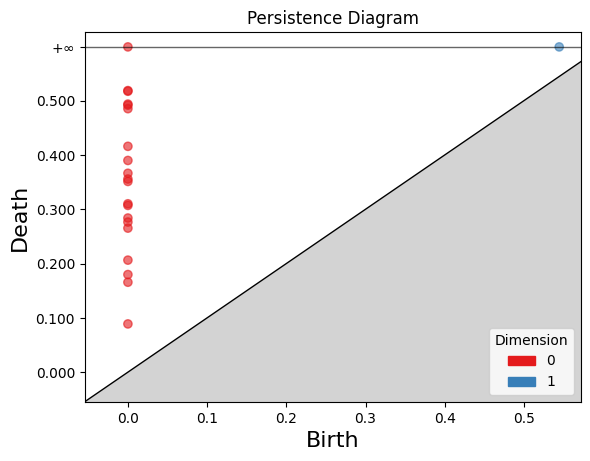

/tmp/ipykernel_3030903/1458467890.py:31: UserWarning: Falling back to manual Betti computation from persistence intervals.
  warnings.warn("Falling back to manual Betti computation from persistence intervals.", UserWarning)


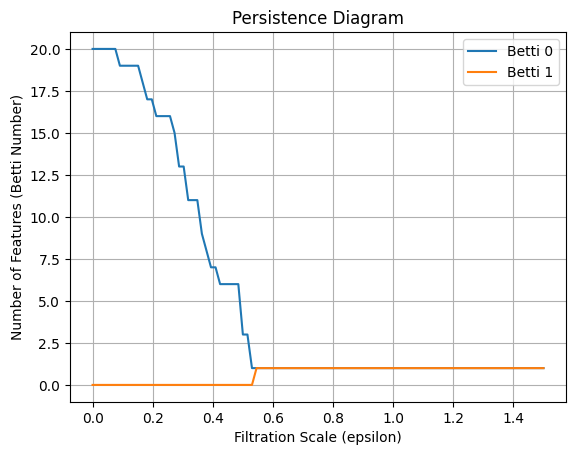


Analysis complete.


In [8]:

# --- Example Usage ---
# 1. Create sample data
num_points = 20
radius = 1.0
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
sample_points = np.array([[radius * np.cos(a), radius * np.sin(a)] for a in angles])
sample_points += np.random.normal(scale=0.1, size=sample_points.shape)
print("Generated Sample Point Cloud (first 5 points):\n", sample_points[:5])
print("-" * 30)

# 2. Compute Persistence using the function
max_filt_scale = 1.5
max_hom_dim = 2 # Compute H0, H1

persistence_intervals, st = compute_persistence(sample_points,
                                                max_edge_length=max_filt_scale,
                                                max_dimension=max_hom_dim)

print("\nComputed Persistence Intervals:")
# Handle potential empty persistence list
if persistence_intervals:
    for dim, (birth, death) in persistence_intervals:
        death_str = f"{death:.4f}" if not np.isinf(death) else "inf"
        print(f"  Dim {dim}: [{birth:.4f}, {death_str})")
else:
    print("  No persistence intervals computed.")
print("-" * 30)

# 3. Plot Persistence Diagram
if persistence_intervals:
    plot_persistence_diagram(persistence_intervals)
else:
    print("Skipping persistence diagram plot (no intervals).")


# 4. Compute and Plot Betti Curves
threshold_values = np.linspace(0, max_filt_scale, 100)
betti_data = compute_betti_curves(st, persistence_intervals, threshold_values)
plot_betti_curves(threshold_values, betti_data)

print("\nAnalysis complete.")

In [9]:
def load_dataset(json_file, safe_img_dir, nsfw_img_dir):
    """
    Load the dataset from the JSON file and prepare data for retrieval.
    
    Args:
        json_file: Path to the ViSU-Text JSON file
        safe_img_dir: Directory containing COCO images
        
    Returns:
        safe_texts: List of safe text descriptions
        safe_image_paths: List of paths to corresponding safe images
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    safe_texts = []
    safe_image_paths = []
    nsfw_texts = []
    nsfw_image_paths = []
    
    for item in data:
        safe_text = item["safe"]
        nsfw_text = item["nsfw"]
        coco_id = item["coco_id"]
        nsfw_id = "flux_" + str(item["incremental_id"])
        safe_img_path = os.path.join(safe_img_dir, f"{coco_id}.jpg")
        nsfw_img_path = os.path.join(nsfw_img_dir, f"{nsfw_id}.png")
        if os.path.exists(safe_img_path):
            safe_texts.append(safe_text)
            safe_image_paths.append(safe_img_path)
        if os.path.exists(nsfw_img_path):
            nsfw_texts.append(nsfw_text)
            nsfw_image_paths.append(nsfw_img_path)
    print(f"Loaded {len(safe_texts)} safe texts and {len(nsfw_texts)} NSFW texts")
    print(f"Loaded {len(safe_image_paths)} safe images and {len(nsfw_image_paths)} NSFW images")
    
    return safe_texts, safe_image_paths, nsfw_texts, nsfw_image_paths

def load_dataset_with_pairs(json_file, safe_img_dir, nsfw_img_dir):
    """
    Load the dataset from the JSON file with paired safe/NSFW content.
    
    Args:
        json_file: Path to the ViSU-Text JSON file
        safe_img_dir: Directory containing safe images
        nsfw_img_dir: Directory containing NSFW images
        
    Returns:
        pairs: List of dictionaries containing paired safe/NSFW content
        all_texts: List of all texts (safe + NSFW)
        all_image_paths: List of all image paths (safe + NSFW)
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    pairs = []
    all_texts = []
    all_image_paths = []
    
    for item in data:
        safe_text = item["safe"]
        nsfw_text = item["nsfw"]
        coco_id = item["coco_id"]
        nsfw_id = "flux_" + str(item["incremental_id"])
        
        safe_img_path = os.path.join(safe_img_dir, f"{coco_id}.jpg")
        nsfw_img_path = os.path.join(nsfw_img_dir, f"{nsfw_id}.png")
        
        # Only include if both images exist
        if os.path.exists(safe_img_path) and os.path.exists(nsfw_img_path):
            pairs.append({
                "safe_text": safe_text,
                "nsfw_text": nsfw_text,
                "safe_img_path": safe_img_path,
                "nsfw_img_path": nsfw_img_path
            })
            all_texts.extend([safe_text, nsfw_text])
            all_image_paths.extend([safe_img_path, nsfw_img_path])
    
    print(f"Loaded {len(pairs)} paired safe/NSFW items")
    print(f"Total texts: {len(all_texts)}, Total images: {len(all_image_paths)}")
    
    return pairs, all_texts, all_image_paths

In [10]:
json_file = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/ViSU-Text_test.json"
safe_img_dir = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/image/test_coco"  # Update with actual path
nsfw_image_dir = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/image/test_nsfw_flux_sldr"  # Update with actual path
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load data
print("Loading dataset...")
safe_texts, safe_image_paths, nsfw_texts, nsfw_image_paths = load_dataset(json_file, safe_img_dir, nsfw_image_dir)
# Load paired data for NSFW evaluations
print("Loading paired dataset...")
pairs, all_texts, all_image_paths = load_dataset_with_pairs(json_file, safe_img_dir, nsfw_image_dir)

Loading dataset...
Loaded 5000 safe texts and 5000 NSFW texts
Loaded 5000 safe images and 5000 NSFW images
Loading paired dataset...
Loaded 5000 paired safe/NSFW items
Total texts: 10000, Total images: 10000


In [11]:
def load_clip(model_name="ViT-L/14", device="cuda"):
    if model_name == "longclip":
        print("Loading Long-CLIP model...")
        model, preprocess = longclip.load("/home/muzammal/Projects/safe_proj/long_safe_clip/weights/longclip-L.pt", device=device)
        tokenizer = longclip.tokenize
    elif model_name == "ViT-L/14":
        print("Loading CLIP model...")
        model, preprocess = clip.load(model_name, device=device)
        tokenizer = clip.tokenize
    return model, preprocess, tokenizer

In [14]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        return self.tokenizer([self.texts[idx]])

class ImageDataset(Dataset):
    def __init__(self, image_paths, preprocess):
        self.image_paths = image_paths
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        return self.preprocess(image)

def extract_text_embeddings(texts, clip_model, tokenizer, device="cuda", batch_size=32):
    text_dataset = TextDataset(texts, tokenizer)
    text_dataloader = DataLoader(text_dataset, batch_size=batch_size)
    text_features = []
    with torch.no_grad():
        for batch in tqdm(text_dataloader, desc="Extracting text features"):
            batch = batch.to(device)
            batch = batch.squeeze(1)
            batch_features = clip_model.encode_text(batch)
            text_features.append(batch_features)
     
    text_features = torch.cat(text_features).to(device)
    text_features = F.normalize(text_features, dim=1)
    print(f"text_features shape: {text_features.shape}")
    return text_features.cpu().numpy()


def extract_image_embeddings(image_paths, clip_model, preprocess, device="cuda", batch_size=16):
    image_features = []
    with torch.no_grad():
        for batch in tqdm(image_dataloader, desc="Extracting image features"):
            batch = batch.to(device)
            batch = batch.squeeze(1)
            batch_features = clip_model.encode_image(batch)
            image_features.append(batch_features)
            
    image_features = torch.cat(image_features).to(device)
    image_features = F.normalize(image_features, dim=1)
    print(f"image_features shape: {image_features.shape}")
    return image_features.cpu().numpy()


def analyze_and_plot_tda(embeddings, label, max_filt_scale, max_hom_dim, threshold_count):
    print(f"\n--- Analyzing {label} Embeddings ({embeddings.shape[0]} samples) ---")
    persistence_intervals, st = compute_persistence(embeddings,
                                                    max_edge_length=max_filt_scale,
                                                    max_dimension=max_hom_dim)
    threshold_values = np.linspace(0, max_filt_scale, threshold_count)
    betti_data = compute_betti_curves(st, persistence_intervals, threshold_values)

    print(f"\nPlotting {label} results...")
    plot_persistence_diagram(persistence_intervals, title=f"Persistence Diagram ({label})")
    plot_betti_curves(threshold_values, betti_data, title=f"Betti Curve ({label})")
    return persistence_intervals, betti_data


model_name = "ViT-L/14"  # or "longclip"
clip_model, clip_preprocess, clip_tokenizer = load_clip(model_name, device)
print("-" * 30)

# --- Option A: Analyze Text Embeddings ---
print("Extracting safe TEXT embeddings...")
safe_text_embeddings = extract_text_embeddings(safe_texts, clip_model, clip_tokenizer, device, batch_size=32)
print("Extracting nsfw TEXT embeddings...")
nsfw_text_embeddings = extract_text_embeddings(nsfw_texts, clip_model, clip_tokenizer, device, batch_size=32)
analysis_label = "Text"

# --- Option B: Analyze Image Embeddings ---
# print("Extracting safe IMAGE embeddings...")
# safe_image_embeddings = extract_image_embeddings(safe_image_paths, clip_model, clip_preprocess, device, BATCH_SIZE_IMAGE)
# print("Extracting nsfw IMAGE embeddings...")
# nsfw_image_embeddings = extract_image_embeddings(nsfw_image_paths, clip_model, clip_preprocess, device, BATCH_SIZE_IMAGE)
# analysis_label = "Image"

Loading CLIP model...
------------------------------
Extracting safe TEXT embeddings...


Extracting text features: 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


text_features shape: torch.Size([5000, 768])
Extracting nsfw TEXT embeddings...


Extracting text features: 100%|██████████| 157/157 [00:06<00:00, 24.40it/s]

text_features shape: torch.Size([5000, 768])


In [ ]:
print("-" * 30)
# 5. Perform TDA and Plot
# Rely on errors from analyze_and_plot_tda if issues occur (e.g., empty embeddings fed in)
persistence_safe, betti_safe = analyze_and_plot_tda(safe_text_embeddings[:1000], f"SAFE {analysis_label}",max_filt_scale=1.5,max_hom_dim=2,threshold_count=100)

persistence_nsfw, betti_nsfw = analyze_and_plot_tda(nsfw_text_embeddings[:1000], f"nsfw {analysis_label}",max_filt_scale=1.5,max_hom_dim=2,threshold_count=100)
print("-" * 30)

------------------------------

--- Analyzing SAFE Text Embeddings (1000 samples) ---
